# Model selection

In [1]:
%load_ext autoreload
%autoreload 2
import latenta as la
import lacell as lac
import numpy as np

We'll use the same dataset as [before](./1-variables).

In [2]:
import scanpy as sc

adata = la.data.load_myod1()
adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])
adata.var["label"] = adata.var["symbol"]
adata.raw = adata

When we say that a model is statistically significant, what we actually mean is that one model is much more likely to be true than another _simpler_ model. In classical statistical testing these two models are called the alternative hypothesis and the null hypothesis.

While statistical testing is powerful for some models, it often falls short when we try to do anything more complex. If we for example include any cellular latent variables, it becomes impossible to calculate any reasonable p-value. Furthermore, if we want to compare many different models.

One main reason to thus use probabilistic modelling is that it allows us to generalize statistical testing to a technique called model selection. In this way, we can even In a probabilistic setting, the generalization of statistical testing is called model selection.

## Creating the models

We will illustrate model selection with perhaps the simplest model possible: differential expression. We are given an outcome, the overexpression of Myod1, and now want to know which genes are differential. To do this, we will create 3 models: a linear response, a non-linear spline response, and a constant response.

At this stage, the following model-building sections should not hold any mysteries for you and are undocumented. Feel free to try out any extra models, e.g. a {class}`latenta.links.scalar.Switch`, or play with some of the parameters of the spline function to see how this affects the outcome.

In [3]:
models = {}

In [4]:
overexpression = la.Fixed(adata.obs["log_overexpression"], label="overexpression")

### Model 1: Linear

In [5]:
transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata)
foldchange = transcriptome.find("foldchange")

foldchange.overexpression = la.links.scalar.Linear(
    overexpression, a=True, definition=foldchange.value_definition
)
foldchange.plot()

  0%|                                                                                                         …

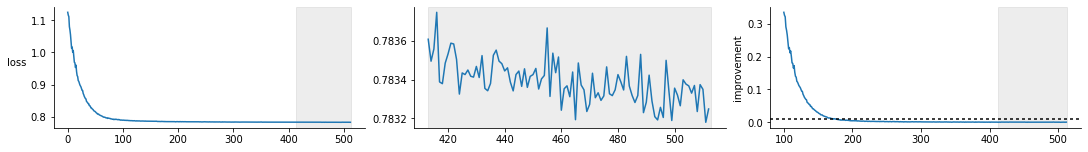

In [6]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot(show = True)

In [7]:
transcriptome_observed = la.posterior.vector.VectorObserved(transcriptome)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
overexpression_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression,
    transcriptome,
    interpretable=transcriptome.p.mu.expression,
    observed=overexpression_observed,
)
overexpression_causal.sample(10)
overexpression_causal.sample_random(10)
overexpression_causal.observed
overexpression_causal.sample_empirical()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

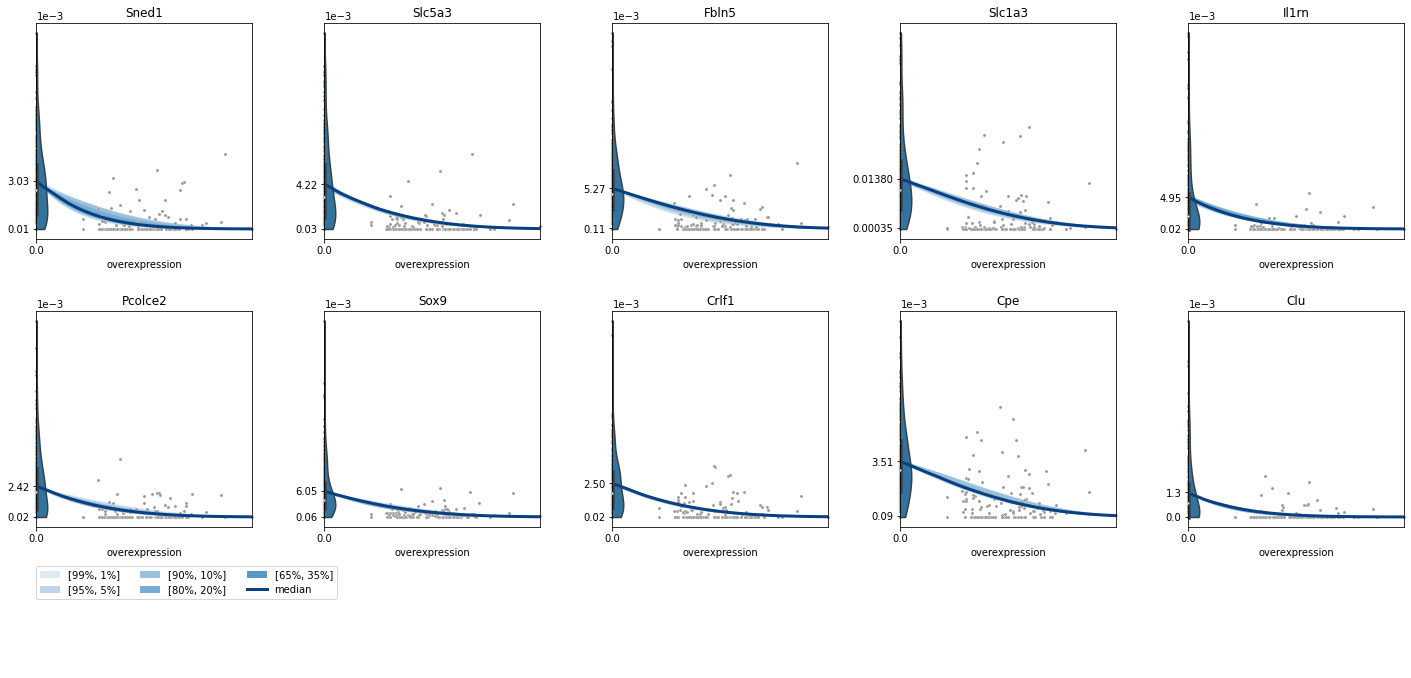

In [10]:
overexpression_causal.plot_features()

In [11]:
models["linear"] = {
    "root": transcriptome,
    "overexpression_causal": overexpression_causal,
    "transcriptome_observed": transcriptome_observed,
}

### Model 2: Spline

In [12]:
overexpression = overexpression.reset().clone()

In [13]:
transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata)
foldchange = transcriptome.find("foldchange")

foldchange.overexpression = la.links.scalar.Spline(
    overexpression, definition=foldchange.value_definition
)
foldchange.plot()

  0%|                                                                                                         …

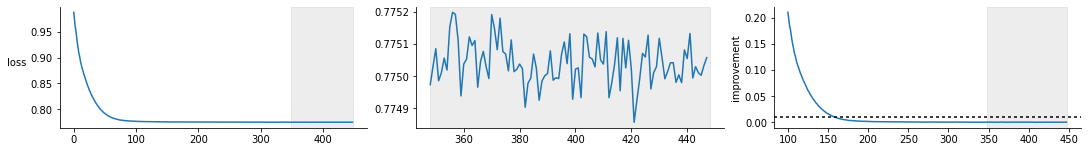

In [14]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot(show = True)

In [15]:
transcriptome_observed = la.posterior.vector.VectorObserved(transcriptome)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
overexpression_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression,
    transcriptome,
    interpretable=transcriptome.p.mu.expression,
    observed=overexpression_observed,
)
overexpression_causal.sample(10)
overexpression_causal.sample_random(10)
overexpression_causal.observed
overexpression_causal.sample_empirical()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

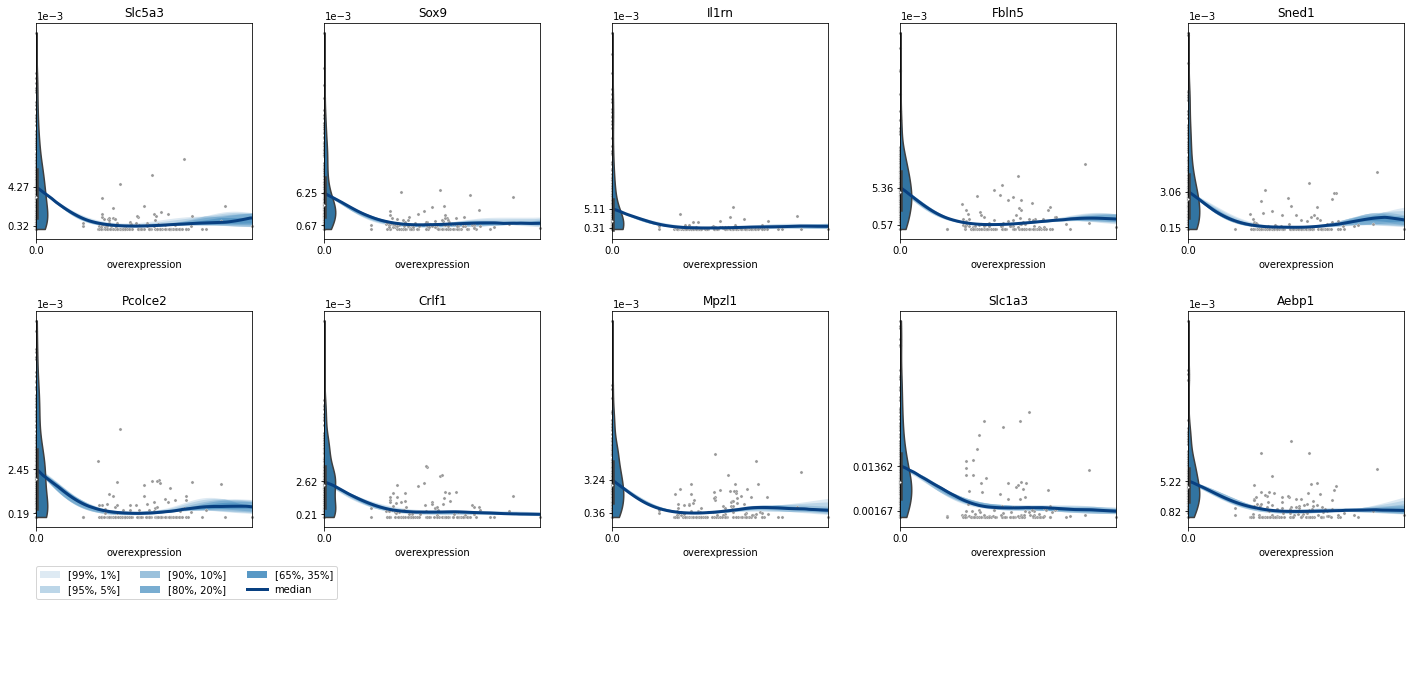

In [18]:
overexpression_causal.plot_features()

In [19]:
models["spline"] = {
    "root": transcriptome,
    "overexpression_causal": overexpression_causal,
    "transcriptome_observed": transcriptome_observed,
}

### Model 3: Constant

In [20]:
overexpression = overexpression.reset().clone()

In [21]:
transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata)
foldchange = transcriptome.find("foldchange")

foldchange.overexpression = la.links.scalar.Constant(
    overexpression, definition=foldchange.value_definition
)
foldchange.plot()

  0%|                                                                                                         …

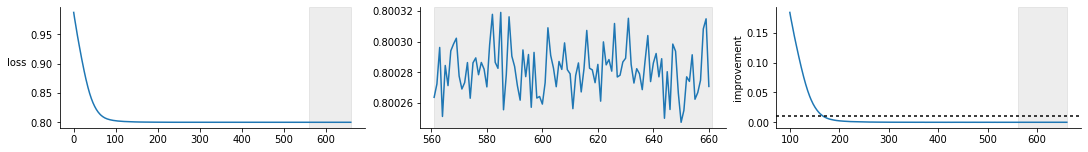

In [22]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot(show = True)

In [23]:
transcriptome_observed = la.posterior.vector.VectorObserved(transcriptome)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
overexpression_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression,
    transcriptome,
    interpretable=transcriptome.p.mu.expression,
    observed=overexpression_observed,
)
overexpression_causal.sample(10)
overexpression_causal.sample_random(10)
overexpression_causal.observed
overexpression_causal.sample_empirical()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

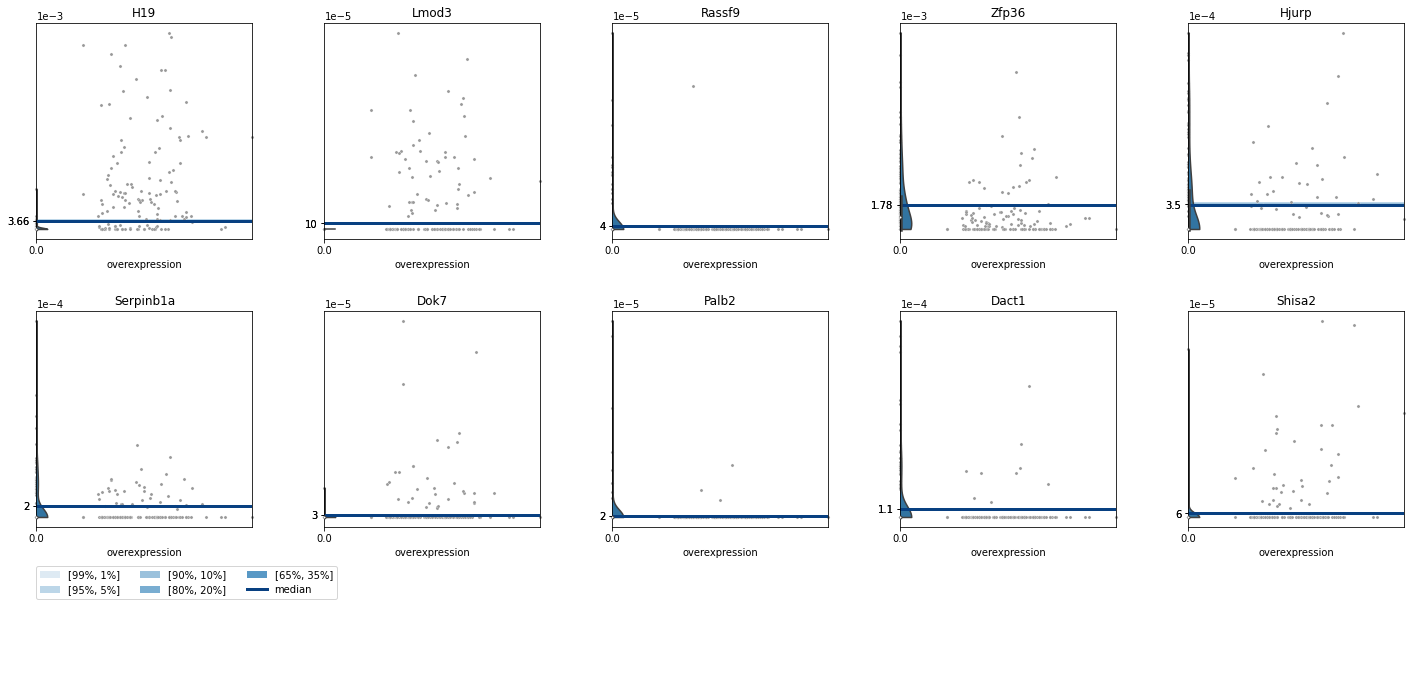

In [26]:
overexpression_causal.plot_features()

In [27]:
models["constant"] = {
    "root": transcriptome,
    "overexpression_causal": overexpression_causal,
    "transcriptome_observed": transcriptome_observed,
}

## Model selection

### The Bayes factor

How do we compare models? Because we are creating probabilistic models, it makes sense to also compare models using with probabilities. But how to define such a measure?

Let's again remind ourselves what we're trying to do. All we have is two things:
- The data, which we further denote as $\mathcal{D}$. This contains both the values that we observe, but also the values that we inferred for the latent variables
- One or more models, which we further denote as $\mathcal{M_i}$. This contains both the priors and structure ("hard" priors) of the model.

To calculate the quality of a model $\mathcal{M_i}$, we have to calculate a probability of how well it explains the data $\mathcal{D}$ given the  model, which we call the evidence:

$$
\mathit{evidence} = P(\mathcal{D} | \mathcal{M_i})
$$

The values for the evidence only become meaningful once we start to compare them between models. We often do this by calculating a ratio of evidences between two competing models, also called the Bayes factor $BF$:

$$
\mathit{BF} = \frac{P(\mathcal{D} | \mathcal{M_i})}{P(\mathcal{D} | \mathcal{M_j})}
$$

Bayes factors are quite intuitive: they tell you how much more likely one model is over the other given the data. We often use some rule-of-thumbs to set our cutoffs, e.g. {citel}`kass_bayes_1995`:



|    $\textit{BF}$   	|        Strength of evidence        	| $\log_{10}$$BF$ 	|   $\log BF$  	|
|:---------:	|:----------------------------------:	|:------------:	|:------------:	|
|  1 to 3.2 	| Not worth more than a bare mention 	|   0 to 1/2   	|   0 to ~1.1  	|
| 3.2 to 10 	|             Substantial            	|   1/2 to 1   	| ~1.1 to ~2.3 	|
| 10 to 100 	|               Strong               	|    1 to 2    	| ~2.3 to ~4.6 	|
|   > 100   	|              Decisive              	|      > 2     	|    > ~4.6    	|

Although the goal of both p-values and Bayes factors may look similar, they do have a different interpretation. p-values quantify the evidence that we have to reject a null hypothesis, but does not provide any evidence in favor of an alternative hypothesis. In contrast, Bayes factors directly compare two models against each other, and include both the "null hypothesis model" and "alternative model" into the calculation.

Furthermore, a Bayes factor considers the complete model _including prior distributions_. The further away the latent variable strays from the priors, the more it will be penalized. Moreover, the more latent variables we have, the more a model will be penalized as each of these latent variables has a prior distribution that needs to be satisfied. In other words, the more complex a model is, the higher the penality will be.

Of course, this is all balanced out with the presence of observed data. If we have a lot of data, more complex models will be able to overcome this penality if they explain the data well. In other words:

> Extraordinary claims require extraordinary evidence

You may have noticed a pattern here: in the [regression tutorial](2-regression) tutorial we also talked about balancing the needs of the priors . This is no coincidence as both model inference and model comparison are highly linked mathematically. Indeed, to estimate Bayes factors we use exactly the same loss function as we typically use for inference: the evidence lower bound or ELBO. This is only an estimation of this measure, as calculating the exact Bayes factor is both mathematically impossible and computationally intractable even for moderately complex models.

One final note: in the presence of very large data, almost every more complex model will be significant. You may have already seen this when doing differential expression in single-cell data, as a large number of genes are significant even though the differences between populations may be minor. This is not a problem of design per se (although some may disagree :citel:{squair_confronting_2021}). Rather, we also need to consider biological significance in our models, such as requiring at least a twofold difference.

In [28]:
import pandas as pd

In [29]:
model_ids = list(models.keys())

In [30]:
elbo_genes = pd.DataFrame(
    {
        model_id: model["transcriptome_observed"].elbo_features.to_pandas()
        for model_id, model in models.items()
    }
)
likelihood_genes = pd.DataFrame(
    {
        model_id: model["transcriptome_observed"].elbo_features.to_pandas()
        for model_id, model in models.items()
    }
)

In [31]:
elbo_genes

,linear,spline,constant
gene,,,
ENSMUSG00000000031,-1051.437886,-993.166651,-1102.082213
ENSMUSG00000000058,-982.530602,-980.113554,-996.612833
ENSMUSG00000000078,-1758.630544,-1750.361311,-1786.250226
ENSMUSG00000000184,-1713.242255,-1706.716673,-1719.001220
ENSMUSG00000000202,-186.211697,-176.448808,-229.657460
...,...,...,...
ENSMUSG00000117278,-142.341339,-142.513606,-143.249725
ENSMUSG00000117515,-245.586816,-247.010978,-243.851159
ENSMUSG00000117710,-107.729979,-108.973972,-108.913724


### Comparing constant versus all other models

First, we can find generally differentially expressed genes by simply comparing the constant model with all other models:

In [32]:
bfs = elbo_genes.drop(columns="constant") - elbo_genes["constant"].values[:, None]
scores = bfs.max(1).rename("bf").to_frame()

<AxesSubplot:ylabel='Density'>

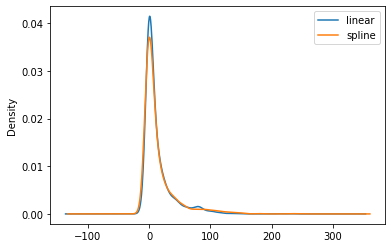

In [33]:
bfs.plot(kind="kde")

In [34]:
scores["symbol"] = adata.var["symbol"][scores.index]
scores = scores.sort_values("bf", ascending=False)
scores

,bf,symbol
gene,,
ENSMUSG00000028464,237.164920,Tpm2
ENSMUSG00000037062,231.052767,Sh3glb1
ENSMUSG00000091898,181.184898,Tnnc1
ENSMUSG00000026459,175.691058,Myog
ENSMUSG00000056612,155.269933,Ppp1r14b
...,...,...
ENSMUSG00000006494,-5.367046,Pdk1
ENSMUSG00000021733,-5.555102,Slc4a7
ENSMUSG00000021846,-5.684643,Peli2


In [35]:
plot = models["spline"]["overexpression_causal"].plot_features(
    feature_ids=scores.index[:5]
)
plot.suptitle("Differential genes")
plot = models["spline"]["overexpression_causal"].plot_features(
    feature_ids=scores.query("bf > log(10)").index[-5:]
)
plot.suptitle("Barely differential genes")
plot = models["spline"]["overexpression_causal"].plot_features(
    feature_ids=scores.index[-5:]
)
plot.suptitle("Non-differential genes")

Text(0.5, 0.98, 'Non-differential genes')

:::{note}

Working with these different models and posteriors may feel quite cumbersome, with tons of repeated code for each model. We agree! That's why in the next tutorial, you're going to see our approach at making these things easier to scale up and maintaining persistence of models across session.

:::

### Comparing spline and linear

In [36]:
scores = (elbo_genes["spline"] - elbo_genes["linear"]).rename("bf").to_frame()
scores["bf_constant"] = bfs.max(1)
scores = scores.query("bf_constant > log(10)")

In [37]:
scores["symbol"] = adata.var["symbol"][scores.index]
scores = scores.sort_values("bf", ascending=False)
scores

,bf,bf_constant,symbol
gene,,,
ENSMUSG00000026459,87.380047,175.691058,Myog
ENSMUSG00000017300,85.747568,131.628146,Tnnc2
ENSMUSG00000061723,78.558294,152.575160,Tnnt3
ENSMUSG00000009214,69.160826,151.256083,Mymk
ENSMUSG00000031097,66.928148,140.799547,Tnni2
...,...,...,...
ENSMUSG00000034850,-7.823109,8.963668,Tmem127
ENSMUSG00000028643,-7.862300,94.894616,Svbp
ENSMUSG00000027602,-8.340743,4.017210,Map1lc3a


In [38]:
nonlinear = scores.query("(bf > log(10))").sort_values("bf_constant", ascending=False)
unclear = scores.query("(bf > log(10)) & (bf < log(30))").sort_values(
    "bf_constant", ascending=False
)
linear = scores.query("(bf < log(10))").sort_values("bf_constant", ascending=False)

Text(0.5, 0.98, 'Non-linear genes')

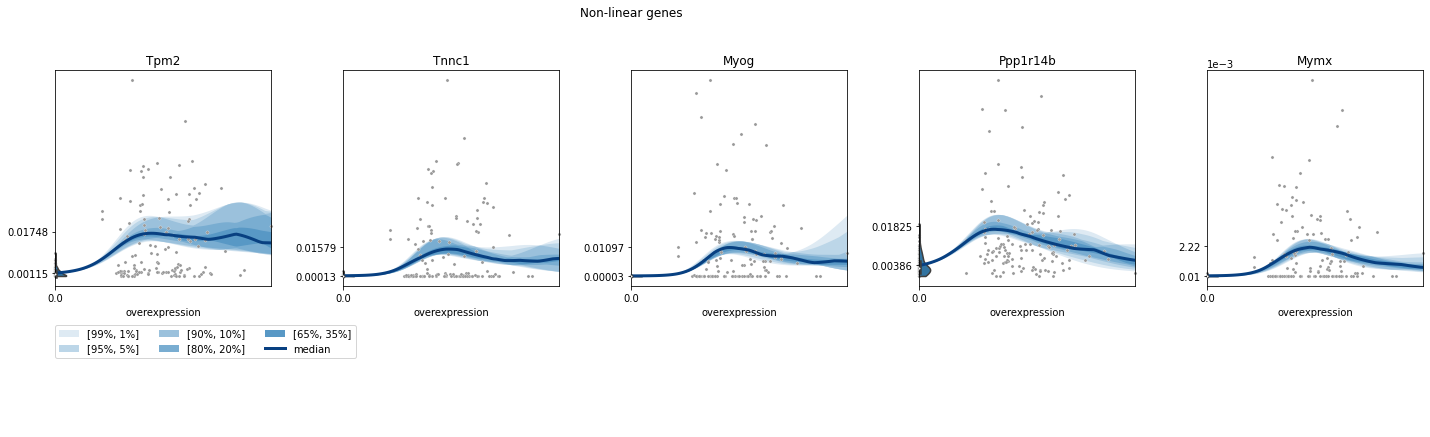

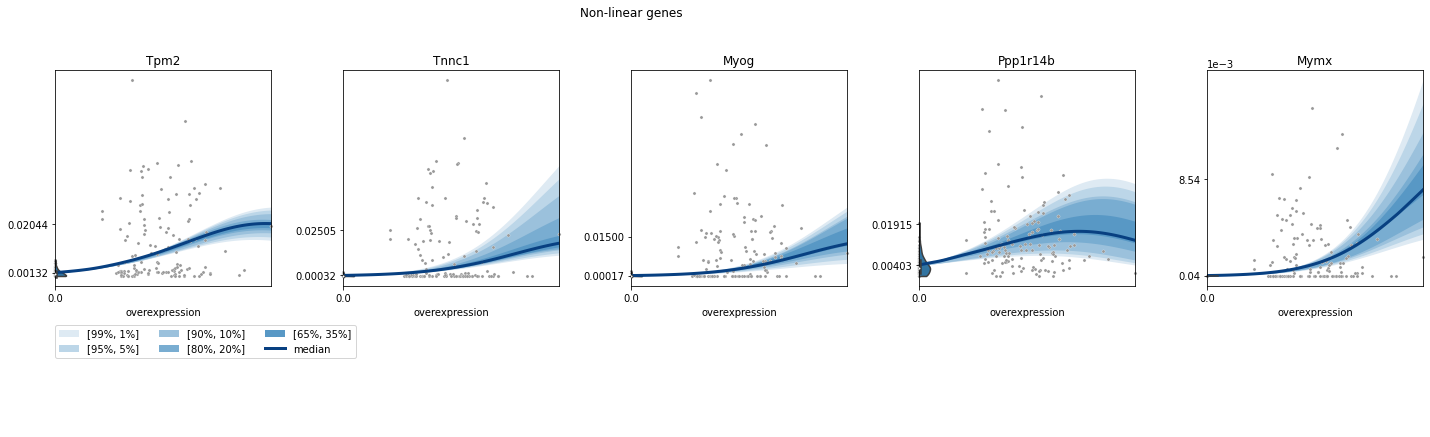

In [39]:
plot = models["spline"]["overexpression_causal"].plot_features(
    feature_ids=nonlinear.index[:5], show = True
)
plot.suptitle("Non-linear genes")
plot = models["linear"]["overexpression_causal"].plot_features(
    feature_ids=nonlinear.index[:5], show = True
)
plot.suptitle("Non-linear genes")

Text(0.5, 0.98, 'Linear genes')

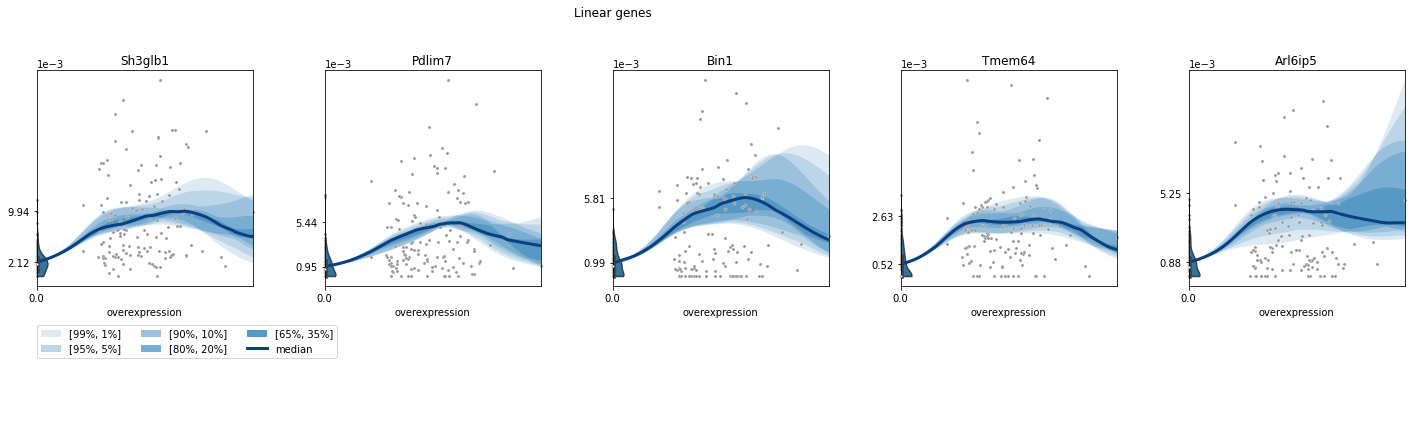

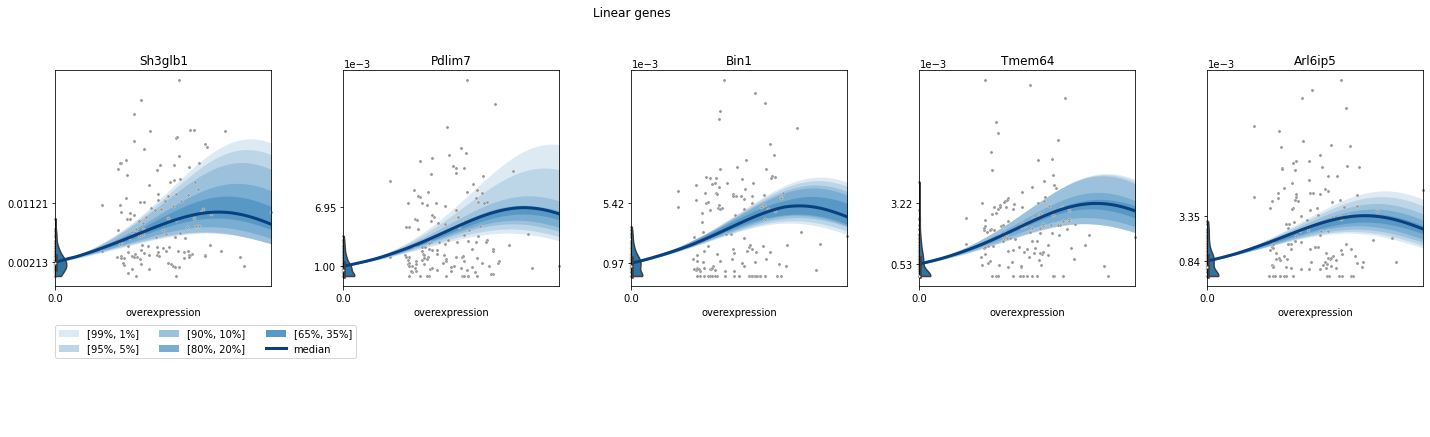

In [40]:
plot = models["spline"]["overexpression_causal"].plot_features(
    feature_ids=linear.index[:5], show = True
)
plot.suptitle("Linear genes")
plot = models["linear"]["overexpression_causal"].plot_features(
    feature_ids=linear.index[:5], show = True
)
plot.suptitle("Linear genes")

Text(0.5, 0.98, 'Unclear genes')

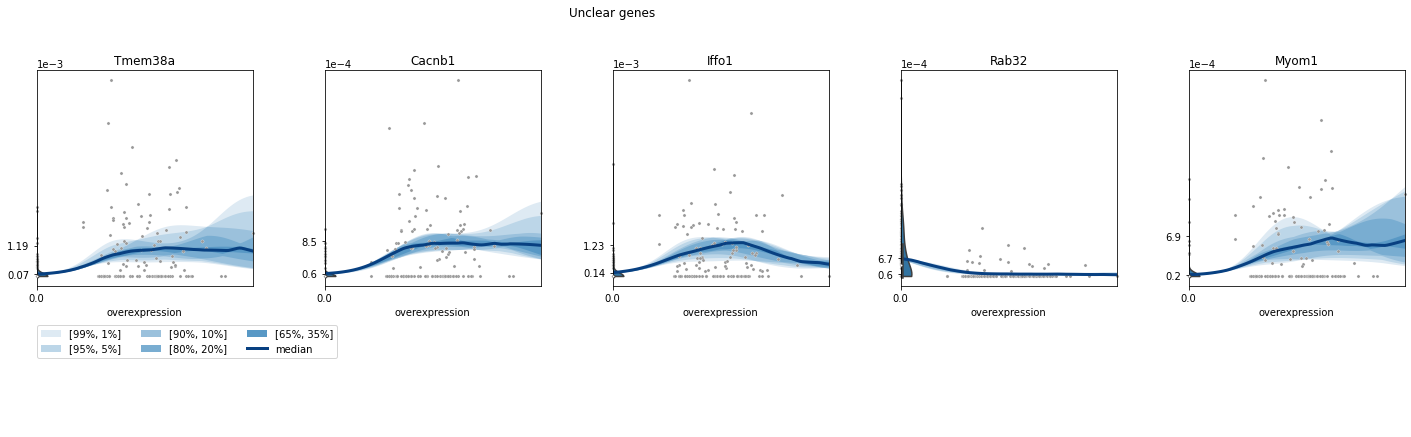

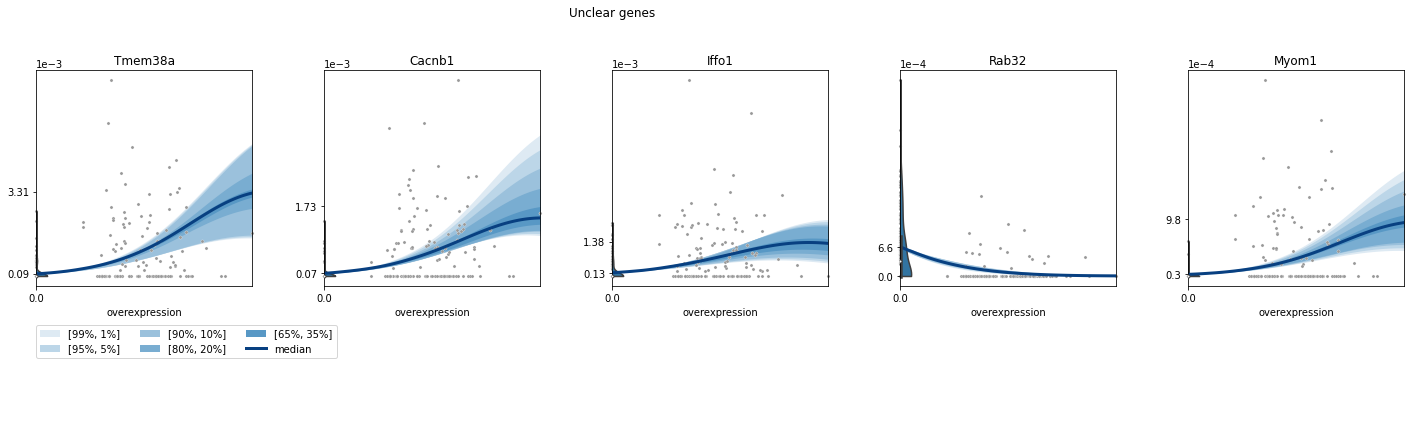

In [41]:
plot = models["spline"]["overexpression_causal"].plot_features(
    feature_ids=unclear.index[:5], show = True
)
plot.suptitle("Unclear genes")
plot = models["linear"]["overexpression_causal"].plot_features(
    feature_ids=unclear.index[:5], show = True
)
plot.suptitle("Unclear genes")